# <p style="text-align:center;"><strong><u>MovieLens Tagging Data Research</u></strong></p>
## This notebook demonstrates my research for the MovieLens group where we try to connect movie tags to movie recommendations. The overall end goal of this project is to be able to recommend movies based on which tags the users on the MovieLens website are having a positive interaction with. This means that a user puts a "+1" for that tag on that specific movie. 

###  </u> <p style="text-align:center;"><strong><u>10/26-11/16/23</u></strong></p>

##### Shown below is the code that I wrote when I tried to correlate user-affect interaction with the names of different actors/actresses. We tried looking through this through random "active" movie data to see if there was sufficient "starter" data for the tagging system. By doing this we are hoping we could dive deeper into this aspect of the database to have a better understanding of how to recommend movies that users could like. 

In [38]:
import mysql.connector
import csv
import random

def get_user_input():
    while True:
        try:
            num_movies = int(input("Enter the number of movies you want to print: "))
            if num_movies > 0:
                return num_movies
            else:
                print("Please enter a positive number.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

db_config = {
    "host": "127.0.0.1",
    "user": "readonly",
    "password": "",
    "database": "ML3_mirror"
}

conn = mysql.connector.connect(**db_config)
cursor = conn.cursor()

movies = []

# Fetches movie data
query = "SELECT movieID, title, directedBy, starring FROM movie_data WHERE movieStatus = 2 AND rowType = 11"
cursor.execute(query)

# Loops through movies to get title, directedBy, and Starring within the database
for (movieID, title, directedBy, starring) in cursor:
    movie_info = {
        "movieID": movieID,
        "title": title,
        "directedBy": directedBy.split(", "),
        "starring": starring.split(", ")
    }
    movies.append(movie_info)

# Gets the number of movies the user wants to print
num_movies_to_print = get_user_input()

# Ensures at least num_movies_to_print unique movies are selected
selected_movies = random.sample(movies, num_movies_to_print)

# Writes statistics for the selected random movies and relevant tags to a CSV file
csv_filename = "random_movies_statistics.csv"

with open(csv_filename, "w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)

    # Writes header
    csv_writer.writerow(["Movie Title", "Tag", "Affect Percentage"])

    # Loops through each random movie
    for movie in selected_movies:
        movie_title = movie["title"]

        tag_stats = {}

        # Fetches tag data for the current movie and actors
        query = f"SELECT tag, uniqueUsers, totalPositive FROM tag_data WHERE tag IN ({', '.join(['%s']*len(movie['starring']))})"
        cursor.execute(query, movie['starring'])

        # Gets tag, uniqueUsers, and totalPositive values for the current movie
        for (tag, uniqueUsers, totalPositive) in cursor:
            tag_stats[tag] = {
                "uniqueUsers": uniqueUsers,
                "totalPositive": totalPositive,
            }

        # Checks if there are tags related to the actors and actresses in the selected movie
        if not tag_stats:
            # Writes a row to the CSV file indicating no tags were found for the actors in the movie
            csv_writer.writerow([movie_title, "No tags found", "N/A"])
            continue

        user_affect = {}

        # Calculates user influence for the current movie
        for actor in movie["starring"]:
            for tag, stats in tag_stats.items():
                if actor in tag:
                    user_affect[tag] = (
                        user_affect.get(tag, 0) + (stats["totalPositive"] / stats["uniqueUsers"])
                    )

        user_total_affect = sum(user_affect.values())

        # Calculates the percentage of influence for each tag
        user_percentage_influence = {}
        if user_total_affect != 0:
            user_percentage_influence = {
                tag: round((influence / user_total_affect) * 100, 2) for tag, influence in user_affect.items()
            }

        # Writes data for each tag that includes an actor's or actress's name
        for tag, percentage in user_percentage_influence.items():
            csv_writer.writerow([movie_title, tag, '{:.2f}'.format(percentage)])

# Closes the database connection
cursor.close()
conn.close()

print(f"Statistics for {num_movies_to_print} random movies written to {csv_filename}")

: 

In [21]:
import pandas as pd 

In [22]:
data = pd.read_csv("random_movies_statistics.csv")

#### Shown below is the resulting csv file that is outputed with the title of the random movie selected, the tags that were interacted with and the percentage of user-interaction with that tag out of all the tags on that movie.

In [23]:
data.head(30)

,Movie Title,Tag,Affect Percentage
0,Robin Hood: Prince of Thieves (1991),Alan Rickman,29.77
1,Robin Hood: Prince of Thieves (1991),Kevin Costner,16.68
2,Robin Hood: Prince of Thieves (1991),Morgan Freeman,25.21
3,Robin Hood: Prince of Thieves (1991),Christian Slater,16.76
4,Robin Hood: Prince of Thieves (1991),Mary Elizabeth Mastrantonio,11.58
5,The Outer Boroughs,No tags found,NaN
6,A Midsummer Night's Dream - Live at Shakespear...,No tags found,NaN


### </u> <p style="text-align:center;"><strong><u>12/1/23-Present</u></strong></p>

##### As of right now, since we figured out there is clear evidence of sufficient tag data to use for movie recommendation we are attempting to deeper into finding a way to connect the results of tag interactions with another category to recommend movies effectively to users. Below is shown my previous proposal from 12/1/23, and then we had gone on Winter Break and I had not really done anything after the meeting nor have we had another meeting yet.

### Question That is Being Asked: 
     What is the meaning of the valence/total Application of tags in the database?

### Findings: 
    From what I've found in the databases, it appears that when diving deeper into specific tables, the meaning behind numNuetral, numPosiitve, and numNegative is the number of possibilities of effects for each tag. That means that there is only one option for each which means you felt neutral, positive, or Negative for each tag. I tried selecting the counts for what affect through the tag_events table. I believe that this is just the total amount of times that the affect was used for all tags in all of the movies. I'm not exactly sure if this is the correct interpretation of what I was trying to do, or whether or not this is what Daniel had asked for at the last meeting, but this is how I understood it. I would love it if somebody from the last meeting would give me feedback on whether or not this is correct. 
### Proposal for Moving Forward: 
    I think that moving forward, it would be interesting to move forward with the idea of figuring out how we can suggest movies based on how users are using the affect on tags. For example, if a user puts a +1 for a tag, then we can use that in-time data to affect the "we think you'd like these movies" section of the website and then it would give movies with that exact tag or similar tags. If a user puts a -1 for a tag then we would find movies that have tags that are opposite of that tag that the user didn't like. If a user uses the neutral affect on the tag then there would be no effect on which movies are recommended. 

#### New proposal as of 1/22/24

##### What if we looked at not only the tags in general but maybe tried to look at more specifically the tags throughout specific genres? We could try to see if there is a similarity in tags for example between actors, themes in movies, or other types of tags in specific genres of movies. Then we could try to recommend movies to users who liked movies in that genre based on the tag that they liked. For example, say John Doe was a tag for one of the movies and then the user puts a "+1" for that tag. Then on the homepage, there could be a section that loads other movies of that genre containing that John Doe tag. I think we have usable the data for this as we have the movie genre data and the tag data in our database. With that data, we can essentially loop through all the different active movies throughout the different genres using real-time user interactions with tags to keep updating the homepage with different tags. 

### Proposal from 2/9 to figure out how to predicit which tags the user might like

**Goal:**
Predict the tags a user will likely prefer based on their past ratings, and estimate what rating they would assign to those tags.

**Proposal for an Equation:**
##### Let's propose a simple equation to calculate the predicted score using the userID, tag, and specific movie $$( S_{ui} )$$ for a $$user ( u )$$ and a $$tag ( i )$$

$$  S_{ui} = \frac{\sum_{j} R_{uj} \cdot W_{ji}}{\sum_{j} |W_{ji}|} $$

#### Where:
##### $$  R_{uj}$$ represents the score that user $$ u $$ has given to movie $$ j $$
#### $$ W_{ji}$$ represents the weight of tag $$ i $$ associated with movie $$ j $$

**Summation Equation:**
#### The summation equation calculates the predicted valence for a user-tag pair by summing the product of the user's ratings for each movie and the weights of the corresponding tags, normalized by the sum of absolute weights.

**Linear Regression Equation:**
##### For a more detailed approach, we can use linear regression to predict user preferences. The linear regression equation would look like:

$$  S_{ui} = \beta_0 + \beta_1 R_{ui} + \epsilon_{ui} $$

### Where:
- ##### $$ S_{ui}$$ is the predicted score for user "u" and tag  "i".
- ##### $$ R_{ui}$$ is the rating given by user "u"  for tag  "i".
- $$ \beta_0 $$ is the intercept.
- $$ \beta_1 $$ is the coefficient for the rating.
- $$ \epsilon_{ui}$$ is the error term.

### My userId is 402850 and Daniel's is 176653, seby's userId is 405309, Ian's is 86716, Romeo's is 407599  tag_events table not tag_ratings, tag_events is the actual ratings of which tag users are interacting with and tag_ratings are just tags that people think that don't apply to movies

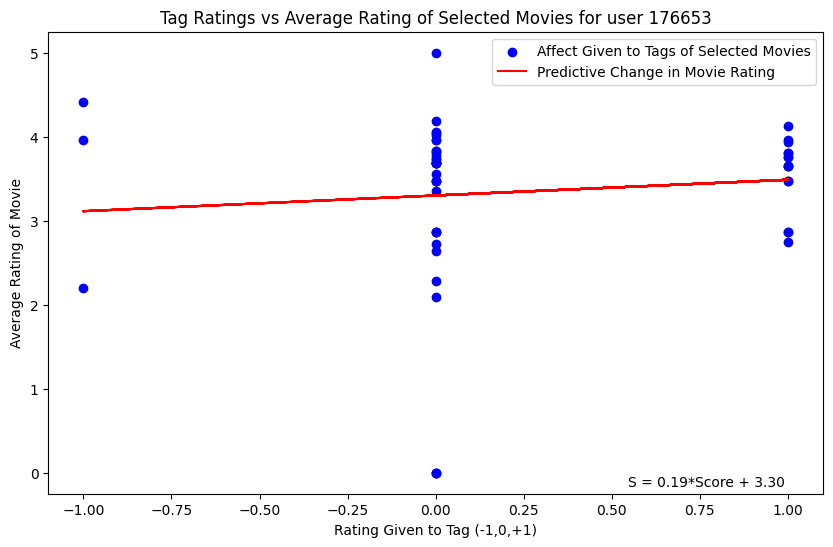

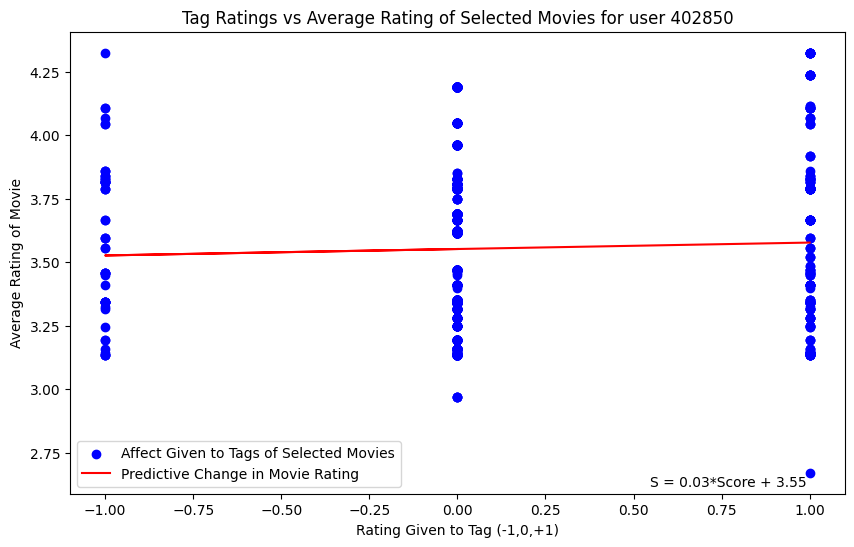

No data found for user_id 86716. Skipping...
No data found for user_id 405309. Skipping...


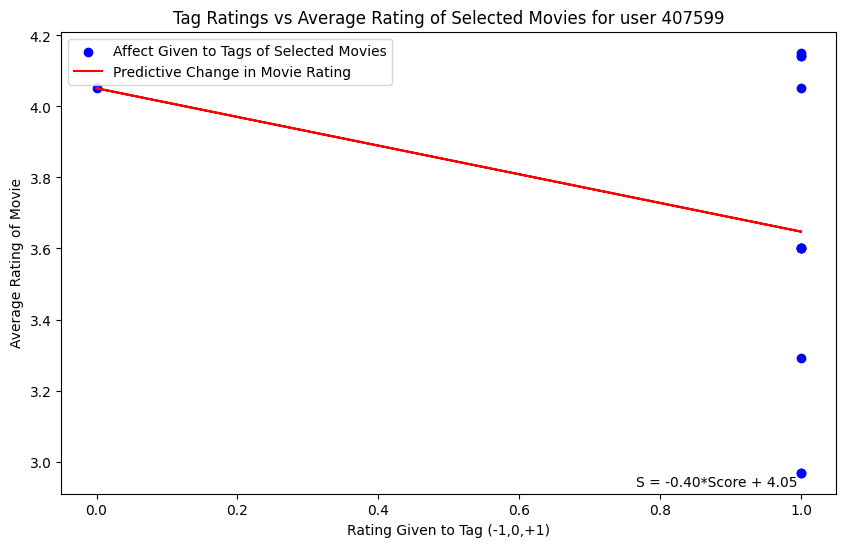

MySQL connection is closed


In [24]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import mysql.connector
from mysql.connector import Error

def calculate_valence(user_id, engine):
    try:
        sql_query = f"""
        SELECT movie_data.movieId, movie_data.title, movie_data.avgRating, tag_events.userId, tag_events.tag, tag_events.affect AS score
        FROM movie_data
        JOIN tag_events ON movie_data.movieId = tag_events.movieId
        WHERE tag_events.userId = {user_id}
        """
        
        df = pd.read_sql(sql_query, engine)
        
        if df.empty:
            print(f"No data found for user_id {user_id}. Skipping...")
            return
        
       
        X = df[['score']]  # Independent variable
        y = df['avgRating']  # Dependent variable

        model = LinearRegression()
        model.fit(X, y)

        beta_0 = model.intercept_
        beta_1 = model.coef_[0]
        
        df['predicted_avgRating'] = model.predict(X)

        plt.figure(figsize=(10, 6))
        plt.scatter(df['score'], df['avgRating'], color='blue', label='Affect Given to Tags of Selected Movies')
        plt.plot(df['score'], df['predicted_avgRating'], color='red', label='Predictive Change in Movie Rating')

        
        equation_text = f'S = {beta_1:.2f}*Score + {beta_0:.2f}'
        plt.text(0.95, 0.01, equation_text, ha='right', va='bottom', transform=plt.gca().transAxes)

        plt.title(f'Tag Ratings vs Average Rating of Selected Movies for user {user_id}')
        plt.xlabel('Rating Given to Tag (-1,0,+1)')
        plt.ylabel('Average Rating of Movie')
        plt.legend()
        plt.show()
        
    except Error as e:
        print(f"Error: {e}")

def main():
    user_ids = [176653, 402850, 86716, 405309, 407599] ## In order, Daniel, Eli, Ian, Seby, and Romeo
    try:
        engine = create_engine("mysql+mysqlconnector://readonly:@127.0.0.1/ML3_mirror")
        
        for user_id in user_ids:
            calculate_valence(user_id, engine)
    except Error as e:
        print(f"Database connection error: {e}")
    finally:
        engine.dispose()
        print("MySQL connection is closed")

if __name__ == "__main__":
    main()

#### As represented from the Plots above, a correlation between the tag affect and movie rating was shown for selected users. In the plots, each point represents the instance in which a user rated a tag for a specific movie. For instance, each point at `1.0` represents each time they upvoted a tag, and the same can be implied for `0` (neutral) or `-1` (dislike this tag). The slope of the line is the rate of change in the predicted Movie Rating due to the change by affect (score) a user may give a tag. The intercept is the average rating of movies from the selected movies for each user when there has been no score inputted.

In [9]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

def fetch_user_movie_tag_correlation(user_id, engine):
    sql_query = """
    SELECT 
        movie_data.movieId, 
        movie_data.title, 
        movie_data.avgRating AS movie_avg_rating, 
        tag_events.tag, 
        AVG(tag_events.affect) AS avg_tag_rating, 
        COUNT(tag_events.tag) AS tag_count
    FROM 
        tag_events 
    JOIN 
        movie_data ON tag_events.movieId = movie_data.movieId
    WHERE 
        tag_events.userId = %s
    GROUP BY 
        movie_data.movieId, tag_events.tag
    ORDER BY 
        movie_data.avgRating DESC, avg_tag_rating DESC
    """
    # Passes parameters as a tuple
    df = pd.read_sql(sql_query, engine, params=(user_id,))
    return df

def save_to_csv(df, filename):
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

def main():
    user_ids = [176653, 402850, 86716, 405309, 407599]  # Example user ID
    engine = create_engine("mysql+mysqlconnector://readonly:@127.0.0.1/ML3_mirror")

    try:
        for user_id in user_ids:
            df = fetch_user_movie_tag_correlation(user_id, engine)
            filename = f"user_{user_id}_movie_tag_correlation.csv"
            save_to_csv(df, filename)
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if engine:
            engine.dispose()
            print("Database connection closed.")

if __name__ == "__main__":
    main()

SystemError: <built-in function isinstance> returned a result with an exception set

### my rating compared to communal tags

In [26]:
import pandas as pd

In [27]:
data = pd.read_csv("user_176653_movie_tag_correlation.csv")
data.head(30)

,movieId,title,movie_avg_rating,tag,avg_tag_rating,tag_count
0,217302,AC/DC: No Bull (1996),5.00000,ac dc,0.0,1
1,318,"Shawshank Redemption, The (1994)",4.41581,boring,-1.0,1
2,912,Casablanca (1942),4.19080,black and white,0.0,1
3,1136,Monty Python and the Holy Grail (1975),4.13310,Monty Python,1.0,1
4,2028,Saving Private Ryan (1998),4.05721,violent,0.0,1
5,68157,Inglourious Basterds (2009),4.04031,seen 2020,0.0,1
6,177765,Coco (2017),4.01953,skelemans,0.0,1
7,34405,Serenity (2005),3.96286,Firefly,0.0,1
8,176371,Blade Runner 2049 (2017),3.96100,cyberpunk,1.0,1
9,176371,Blade Runner 2049 (2017),3.96100,science,0.0,1


In [28]:
data = pd.read_csv("user_402850_movie_tag_correlation.csv")
data.head(30)

,movieId,title,movie_avg_rating,tag,avg_tag_rating,tag_count
0,858,"Godfather, The (1972)",4.32530,organized crime,1.0,1
1,858,"Godfather, The (1972)",4.32530,Al Pacino,1.0,1
2,858,"Godfather, The (1972)",4.32530,Robert De Niro,1.0,1
3,858,"Godfather, The (1972)",4.32530,atmospheric,1.0,1
4,858,"Godfather, The (1972)",4.32530,classic,1.0,1
5,858,"Godfather, The (1972)",4.32530,crime,1.0,1
6,858,"Godfather, The (1972)",4.32530,great acting,1.0,1
7,858,"Godfather, The (1972)",4.32530,mafia,1.0,1
8,858,"Godfather, The (1972)",4.32530,Marlon Brando,1.0,1
9,858,"Godfather, The (1972)",4.32530,too long,-1.0,1


In [29]:
data = pd.read_csv("user_86716_movie_tag_correlation.csv")
data.head(30)

,movieId,title,movie_avg_rating,tag,avg_tag_rating,tag_count


In [30]:
data = pd.read_csv("user_405309_movie_tag_correlation.csv")
data.head(30)

,movieId,title,movie_avg_rating,tag,avg_tag_rating,tag_count


In [31]:
data = pd.read_csv("user_407599_movie_tag_correlation.csv")
data.head(30)

,movieId,title,movie_avg_rating,tag,avg_tag_rating,tag_count
0,109487,Interstellar (2014),4.15138,atmospheric,1.0,1
1,286897,Spider-Man: Across the Spider-Verse (2023),4.14269,animation,1.0,1
2,286897,Spider-Man: Across the Spider-Verse (2023),4.14269,Marvel,1.0,1
3,164179,Arrival (2016),4.05127,aliens,1.0,1
4,164179,Arrival (2016),4.05127,amazing,0.0,1
5,104841,Gravity (2013),3.60126,physics,1.0,1
6,104841,Gravity (2013),3.60126,sci-fi,1.0,1
7,104841,Gravity (2013),3.60126,space,1.0,1
8,104841,Gravity (2013),3.60126,visually stunning,1.0,1
9,4370,A.I. Artificial Intelligence (2001),3.29214,artificial intelligence,1.0,1


SELECT  movie_data.movieId, movie_data.title, user_rating_pairs.rating AS user_rating, tag_events.tag, AVG(tag_events.affect) AS avg_affect,
COUNT(tag_events.tag) AS count  FROM user_rating_pairs JOIN movie_data ON user_rating_pairs.movieId = movie_data.movieId JOIN tag_events ON user_rating_pairs.userId = tag_events.userId AND user_rating_pairs.movieId = tag_events.movieId GROUP BY movie_data.movieId, tag_events.tag ORDER BY movie_data.movieId, AVG(tag_events.affect) DESC limit 20;

In [8]:
import mysql.connector
import pandas as pd

# Database connection
config = {
    "host": "127.0.0.1",
    "user": "readonly",
    "password": "",
    "database": "ML3_mirror"
}

# Query from the MovieLens Database 
query = {
    "tag_info": """
        SELECT 
            md.movieId,
            md.title, 
            urp.rating AS movie_score, 
            te.tag, 
            te.affect AS user_affect, 
            (SELECT AVG(affect) FROM tag_events WHERE tag = te.tag) AS avg_affect_all_users, 
            (SELECT COUNT(*) FROM tag_events WHERE tag = te.tag) AS total_tag_count
        FROM 
            tag_events AS te
        INNER JOIN 
            movie_data AS md ON te.movieId = md.movieId
        INNER JOIN 
            user_rating_pairs AS urp ON md.movieId = urp.movieId AND te.userId = urp.userId
        WHERE 
            te.userId = 402850
        GROUP BY 
            md.movieId, te.tag, urp.rating
        ORDER BY 
            md.movieId;
    """
}
def execute_query(config, query):
    with mysql.connector.connect(**config) as conn:
        with conn.cursor(dictionary=True) as cursor:
            cursor.execute(query)
            result = cursor.fetchall()
            return pd.DataFrame(result)

# Executes the query to fetch the tag information
df_detailed_info = execute_query(config, query["tag_info"])


df_detailed_info.to_csv("tag_info.csv", index=False)

print("Detailed tag information has been successfully saved to tag_info.csv.")

Detailed tag information has been successfully saved to tag_info.csv.


In [9]:
data = pd.read_csv("tag_info.csv")
data.head(50)

,movieId,title,movie_score,tag,user_affect,avg_affect_all_users,total_tag_count
0,19,Ace Ventura: When Nature Calls (1995),3.0,Jim Carrey,1,0.5406,1095
1,104,Happy Gilmore (1996),4.0,Adam Sandler,1,0.2129,634
2,104,Happy Gilmore (1996),4.0,sports,0,0.1588,1316
3,858,"Godfather, The (1972)",5.0,Al Pacino,1,0.7916,1003
4,858,"Godfather, The (1972)",5.0,atmospheric,1,0.9253,13713
5,858,"Godfather, The (1972)",5.0,classic,1,0.6497,6537
6,858,"Godfather, The (1972)",5.0,crime,1,0.5238,4389
7,858,"Godfather, The (1972)",5.0,great acting,1,0.9197,4742
8,858,"Godfather, The (1972)",5.0,mafia,1,0.4649,1766
9,858,"Godfather, The (1972)",5.0,Marlon Brando,1,0.7008,264


The above table displays selected data for my account on the MovieLens website. The table displayes the first 20 movies that I've rated along with the tags that I used and the affect I gave to each tag. It compares my affect to the averagee affect of all users who used that tag nand also it shows the total number of times the tag has been used.

Figure out rating of specific tags across all movies compared to rating of same tags for communal data.

In [16]:
import mysql.connector
import pandas as pd

# Defines the database configuration
config = {
    "host": "127.0.0.1",
    "user": "readonly",
    "password": "",
    "database": "ML3_mirror"
}

try:
    # Connects to the MySQL database
    db_connection = mysql.connector.connect(**config)

    if db_connection.is_connected():
        print("Connected to MySQL database")

        # Defines the SQL query
        sql_query = """
        SELECT 
            T.userTag AS tag,
            T.avgAffect AS avg_affect_user_402850,
            C.avgAffect AS avg_affect_all_users,
            C.tagFrequency
        FROM 
            (
                SELECT 
                    TE.tag AS userTag, 
                    AVG(TE.affect) AS avgAffect
                FROM tag_events TE
                INNER JOIN user_rating_pairs UR ON TE.movieId = UR.movieId 
                WHERE UR.userId = 402850
                GROUP BY TE.tag
            ) T
        JOIN 
            (
                SELECT 
                    tag, 
                    AVG(affect) AS avgAffect,
                    COUNT(*) AS tagFrequency
                FROM tag_events
                GROUP BY tag
            ) C ON T.userTag = C.tag
        ORDER BY C.tagFrequency DESC;
        """

        # Reads data from SQL query directly into a pandas DataFrame
        df = pd.read_sql(sql_query, db_connection)

        # Defines the CSV file path
        csv_file_path = "tag_analysis.csv"

        # Writes the DataFrame to a CSV file
        df.to_csv(csv_file_path, index=False)

        print(f"Data written to {csv_file_path}")

        # Closes the database connection
        db_connection.close()
        print("Database connection closed")
    else:
        print("Failed to connect to MySQL database")

except mysql.connector.Error as e:
    print(f"Error connecting to MySQL database: {e}")

Connected to MySQL database


/var/folders/7k/bnkk4fs54tg15nbz965q881m0000gn/T/ipykernel_29199/3920707038.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, db_connection)


Data written to tag_analysis.csv
Database connection closed


In [17]:
data = pd.read_csv("tag_analysis.csv")
data.head(50)

,tag,avg_affect_user_402850,avg_affect_all_users,tagFrequency
0,sci-fi,0.8273,0.7975,16269
1,atmospheric,0.9671,0.9253,13713
2,action,0.7063,0.6699,12588
3,comedy,0.8015,0.7113,12559
4,funny,0.8767,0.8487,10629
5,surreal,0.8852,0.8268,10097
6,visually appealing,0.9728,0.9498,9899
7,twist ending,0.9284,0.8813,9031
8,dark comedy,0.9044,0.8537,8392
9,thought-provoking,0.9636,0.9548,8380
